# News Scrapers

In [196]:
import requests
import json 
import pandas as pd
import html2text
import tqdm.notebook as tqdm
import copy
import numpy as np
import matplotlib.pyplot as plt

GUARDIAN_API_KEY =  "6c15c612-076e-4fff-9023-194e033a4c85"

## Utility Functions

In [51]:
def print_json(results): 
    print(json.dumps(results, indent=2))

h = html2text.HTML2Text()
h.ignore_links = True

## Guardian

1. Get total number of pages of articles containing the words "coronavirus" and "covid-19"

In [52]:
search_query = 'coronavirus|covid-19'
from_date = '2019-12-25'
order_by = 'oldest'
page_size = '50'
fields = 'headline'
blocks = 'body'

fetch_url = f'https://content.guardianapis.com/search?q={search_query}&from-date={from_date}&order-by={order_by}&page-size={page_size}&show-fields={fields}&show-blocks={blocks}&api-key={GUARDIAN_API_KEY}'

r = requests.get(fetch_url).json()

number_of_pages = r['response']['pages']


2. Fetch every article from every page

In [133]:
content = {}

content_no = 0

for page in tqdm.tqdm(range(1, number_of_pages + 1)):
    fetch_url = f'https://content.guardianapis.com/search?q={search_query}&from-date={from_date}&order-by={order_by}&page-size={page_size}&show-fields={fields}&show-blocks={blocks}&page={page}&api-key={GUARDIAN_API_KEY}'
    r = requests.get(fetch_url).json()
   
    results = r['response']['results']   

    for result in tqdm.tqdm(results, leave=False):
        
        content[content_no] = {
            'id': result['id'],
            'section': result['sectionName'],
            'date_published': result['webPublicationDate'],
            'headline': result['fields']['headline'],
            'url': result['webUrl'],
            'body': h.handle(result['blocks']['body'][0]['bodyHtml'])
        }
        
        content_no += 1

print(f"Number of articles found: {len(content.keys())}")   


Number of articles found: 2192


3. Preprocess the data to remove any articles without the words "coronavirus" or "covid-19"

In [134]:
ids = list(content.keys())

for id in tqdm.tqdm(ids):
    entry = content[id]
    body = entry['body']
    body = body.split()
        
    no_coronavirus = "coronavirus" not in body
    no_covid19 = "covid-19" not in body
    no_COVID19 = "COVID-19" not in body
        
    if no_coronavirus and no_covid19 and no_COVID19:
        content.pop(id)

# Create final dict with correct article no
processed_content = {}
content_no = 0
        
for id in content.keys():
    processed_content[content_no] = content[id]
    content_no += 1

4. Save data as `json`

In [135]:
with open('news.json', 'w') as fp:
    json.dump(processed_content, fp)

## Visualisations

In [146]:
df = pd.DataFrame(processed_content)

df = df.T
df

,id,section,date_published,headline,url,body
0,sport/2019/dec/31/sport-in-2020-calendar-your-...,Sport,2019-12-31T20:00:44Z,Sport in 2020 calendar: your month-by-month gu...,https://www.theguardian.com/sport/2019/dec/31/...,\n\n * _A number of sporting events have been...
1,world/2020/jan/09/chinas-sars-like-illness-wor...,World news,2020-01-09T19:10:17Z,China's Sars-like illness worries health experts,https://www.theguardian.com/world/2020/jan/09/...,\n\nThe finding that the outbreak of viral pne...
2,world/2020/jan/18/coronavirus-what-airport-mea...,World news,2020-01-18T09:21:23Z,Coronavirus: what airport measures are in plac...,https://www.theguardian.com/world/2020/jan/18/...,\n\nInternational airports are stepping up scr...
3,australia-news/2020/jan/18/coronavirus-austral...,Australia news,2020-01-18T10:29:33Z,Coronavirus: Australia's top health official s...,https://www.theguardian.com/australia-news/202...,\n\nAustralia’s top health official says there...
4,society/2020/jan/18/expert-questions-effective...,Society,2020-01-18T19:20:36Z,Expert questions effectiveness of coronavirus ...,https://www.theguardian.com/society/2020/jan/1...,\n\nMedical staff at airports trying to screen...
...,...,...,...,...,...,...
1765,commentisfree/2020/mar/14/coronavirus-is-first...,Opinion,2020-03-14T19:00:35Z,"Coronavirus is first a health problem, second ...",https://www.theguardian.com/commentisfree/2020...,\n\nAfter the share market fell 7.4% on Monday...
1766,world/2020/mar/14/why-brexit-will-delay-uk-get...,World news,2020-03-14T19:00:56Z,Brexit threatens UK’s ability to respond to a ...,https://www.theguardian.com/world/2020/mar/14/...,\n\nBrexit threatens the UK’s ability to respo...
1767,world/2020/mar/14/coronavirus-vaccine-delays-b...,World news,2020-03-14T19:10:00Z,Brexit means coronavirus vaccine will be slowe...,https://www.theguardian.com/world/2020/mar/14/...,\n\nThe UK faces having to wait longer and pay...
1768,world/2020/mar/14/coronavirus-latest-at-a-glan...,World news,2020-03-14T19:15:54Z,Coronavirus latest: at a glance – 14 March eve...,https://www.theguardian.com/world/2020/mar/14/...,\n\nKey developments in the global coronavirus...


In [201]:
date_frequencies = {}

for id in processed_content:
    entry = processed_content[id]
    date_published = entry['date_published'][:10]
#     date_published = pd.to_datetime(date_published, format='%Y-%m-%d')
    
    if date_published not in date_frequencies.keys():
        date_frequencies[date_published] = 1
    else:
        date_frequencies[date_published] += 1


In [202]:
df = pd.DataFrame(date_frequencies, index=[0])

df

,2019-12-31,2020-01-09,2020-01-18,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15
0,1,1,4,9,7,15,13,6,13,15,...,61,38,40,74,89,114,119,122,62,1


<BarContainer object of 58 artists>

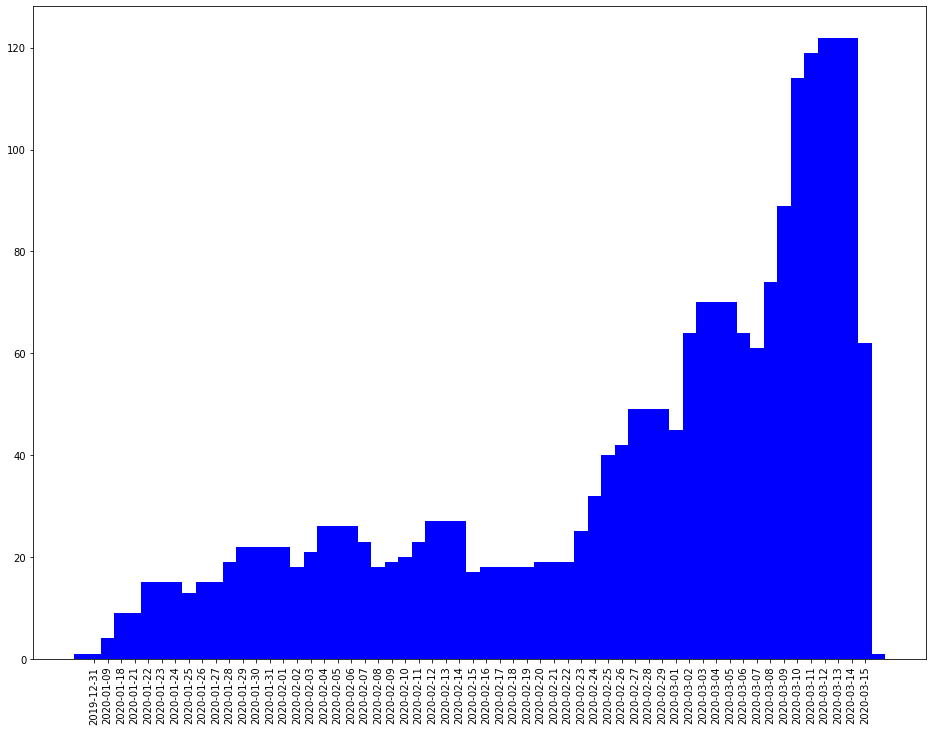

In [215]:
plt.figure(figsize=(16, 12))
plt.xticks(rotation=90)
plt.bar(list(date_frequencies.keys()), list(date_frequencies.values()), 3, color='b')

# plt.figure(figsize=(10, 10))